# TP 3 - Project : Mean Field Game with Congestion Effect


## Import of different modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import scipy

## Market Parameters initialisation


In [ ]:

params = {
    0: (2, 0.1, 1, 0.5, 0.02), # theta = 0.09 & the set of parameters considered for the comparison note that f0_tilda will be put to 0 !
    1: (2, 0.1, 5, 1, 0.02), # theta = 0.09
    2: (2, 0.01, 2, 1.2, 0.1),
    3: (2, 0.01, 2, 1.5, 0.2),
    4: (2, 1, 3, 2, 0.002), # theta = 0.02
}

# Selecting a parameter set
beta, c0, c1, alpha, sigma = params[3] # manually set the parameters here
nu = sigma**2/2
T = 1
Nh = 201 # Number of space grid points
NT = 100 # Number of time grid points
dt = T/NT # Time step
h = 1/(Nh - 1) # Space step
time_ = np.arange(0, T+dt, dt) # Time grid
space_ = np.arange(0, 1+h, h) # Space grid
newton_tol = 1e-12 # 1e-12 Seems to be too small
fixed_point_tol = 1e-6 # Optimally we put 1e-6 but if it takes "too long" we can put 1e-3

theta = 0.09# to be changed depending on the parameter set


We decided to implement function there in order to gain some code lisibility and maintanability latter on.

In [ ]:
def m0(x):
    return np.sqrt(300/np.pi) * np.exp(-300 * (x - 0.2)**2)

def phi(x):
    return -np.exp(-40 * (x - 0.7)**2)

def f0_tilde(m): # To be manually set for comparison
        return m / 10

def m0_hat(x):
    return m0(x)

## Operators for the discrete problems

We transformed the operators deduced from the project sheet and also our computation (you may refer to the report)

In [ ]:
## Spatial Operators

# Derivatives operators : @i
D = np.diag([-1]*Nh) + np.diag([1]*(Nh-1), k=1)
D[Nh-1, Nh-1] = 0 # Boundary condition

# Derivatives operators : @i-1
D_shift = np.diag([1]*Nh) + np.diag([-1]*(Nh-1), k=-1)
D_shift[0, 0] = 0 # Boundary condition

# Laplacian
D_2 = np.diag([-2]*Nh) + np.diag([1]*(Nh-1), k=1) + np.diag([1]*(Nh-1), k=-1)
D_2[0, 0], D_2[Nh-1, Nh-1] = -1, -1 # Boundary conditions
D_2 = D_2/h**2

## Function for solvers

We decided to separate jacobian for H, for the whole problems, residuals and the newtons methods in order to gain in code maintanability :

In [ ]:
def F_(U_n_plus_1, U_n_k, M_n_plus_1):
    F = - (U_n_plus_1 - U_n_k)/dt  - nu*D_2@U_n_k
    F +=  1/beta * (np.minimum(D@U_n_k / h, 0)**2 + (np.maximum(D_shift@U_n_k / h, 0))**2)**(beta/2) * 1 / ((c0 + c1*M_n_plus_1)**alpha)
    F +=  - f0_tilde(M_n_plus_1)

    return F

In [ ]:
def hamiltonian_jacobian(U, M_JH):
    pos = np.maximum(D_shift@U, 0)
    neg = - np.minimum(D@U, 0)
    factor = pos**2 + neg**2
    factor = np.power(factor, beta/2-1, out=np.zeros_like(factor), where=(factor!=0))

    diag = ((1/h**beta)      *(1/((c0 + c1 * M_JH)**alpha))* (neg + pos) * factor) # [i,i]
    diag_p = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  pos * factor)[1:]  #[i+1, i]
    diag_m = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  neg* factor)[:-1]   #[i, i+1]



    ham_jac = np.diag(diag_p, k=-1) + np.diag(diag) + np.diag(diag_m, k=+1) # Dense matrix for solve() methods

    return ham_jac

def jacobian(U, M_JB):
    pos = np.maximum(D_shift@U, 0)
    neg = - np.minimum(D@U, 0)

    factor = pos**2 + neg**2
    factor = np.power(factor, beta/2-1, out=np.zeros_like(factor), where=(factor!=0))

    diag = ((1/h**beta)        *(1/((c0 + c1 * M_JB)**alpha))* (neg + pos) * factor) # [i,i]
    diag_p = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JB)**alpha))*  pos * factor)[1:]  #[i+1, i]
    diag_m = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JB)**alpha))*  neg* factor)[:-1]   #[i, i+1]

    jac = np.zeros((3, U.size))

    jac[0, 1:] = diag_m - nu/h**2
    jac[1] = diag + 1/dt + 2*nu/h**2
    jac[2, :-1] = diag_p - nu/h**2


    return jac

In [ ]:
def newton(U, M):
    U_k = U.copy()

    k = 0 # Iteration counter
    normF = np.inf
    while normF > newton_tol:
        F = F_(U, U_k, M)
        J = jacobian(U_k, M)

        # To avoid numerical error when c0 is too small (as a term will explode) we decide to not divide by delta t but rewrite our equation to solve it
        F *= dt
        J *= dt

        U_k = U_k - scipy.linalg.solve_banded((1, 1), J, F) # Solve the linear system as the matrix is banded we use solve_banded



        normF = np.linalg.norm(F)
        k += 1

    return U_k # Return the solution at the end of the Newton Raphson method


## Solvers

In [ ]:
def solve_HJB(M_HJB):
    U_hat = np.zeros(M_HJB.shape)
    U_hat[NT] = phi(space_)

    # Backward loop
    for n in range(NT-1, -1, -1):
        U_hat[n] = newton(U_hat[n+1], M_HJB[n+1]) # Solve the HJB equation for each time step

    return U_hat # Return the solution of the HJB equation

def solve_KFP(U, M_old):
    M_hat = np.zeros(U.shape)
    M_hat[0] = m0_hat(space_)

    if(M_old == M_hat).all():
        print("M_old = M_hat")  # This should not happen

    # Forward loop
    for n in range(NT):
        JH = hamiltonian_jacobian(U[n], M_old[n+1])
        M_hat[n+1] = np.linalg.solve(np.identity(Nh) - nu*dt*D_2+dt*JH.T, M_hat[n])

    return M_hat

## Main loop

In [ ]:
def Fixed_Point(U_fixed, M_fixed):

    t0 = time.time() # Start time
    k = 0 # Iteration counter

    norm_increment = np.inf # Initialize the norm of the increment


    while norm_increment > fixed_point_tol :
        print(f"Iteration {k}, previous norm: {norm_increment}, theta: {theta}, elapsed time: {time.time() - t0}")

        U_hat = solve_HJB(M_fixed)
        M_hat = solve_KFP(U_hat, M_fixed)

        U_new = (1 - theta) * U_fixed + theta * U_hat
        M_new = (1 - theta) * M_fixed + theta * M_hat

        increment = np.hstack((U_new - U_fixed, M_new - M_fixed))
        norm_increment = np.linalg.norm(increment)
        k += 1

        U_fixed, M_fixed = U_new, M_new

    return U_new, M_new

## Main executions

Iteration 0, previous norm: inf, theta: 0.09, elapsed time: 1.3589859008789062e-05
Iteration 1, previous norm: 33.793025587097446, theta: 0.09, elapsed time: 5.96755576133728
Iteration 2, previous norm: 30.213292079559512, theta: 0.09, elapsed time: 9.751386165618896
Iteration 3, previous norm: 25.262303601940868, theta: 0.09, elapsed time: 14.457844018936157
Iteration 4, previous norm: 22.02505987725604, theta: 0.09, elapsed time: 20.502737998962402
Iteration 5, previous norm: 19.833433861618698, theta: 0.09, elapsed time: 25.0118408203125
Iteration 6, previous norm: 18.10617426756303, theta: 0.09, elapsed time: 31.46684432029724
Iteration 7, previous norm: 16.503658415923752, theta: 0.09, elapsed time: 36.040212869644165
Iteration 8, previous norm: 15.02456915662193, theta: 0.09, elapsed time: 40.80524659156799
Iteration 9, previous norm: 13.686455928733263, theta: 0.09, elapsed time: 47.27625799179077
Iteration 10, previous norm: 12.489780509198349, theta: 0.09, elapsed time: 51.939

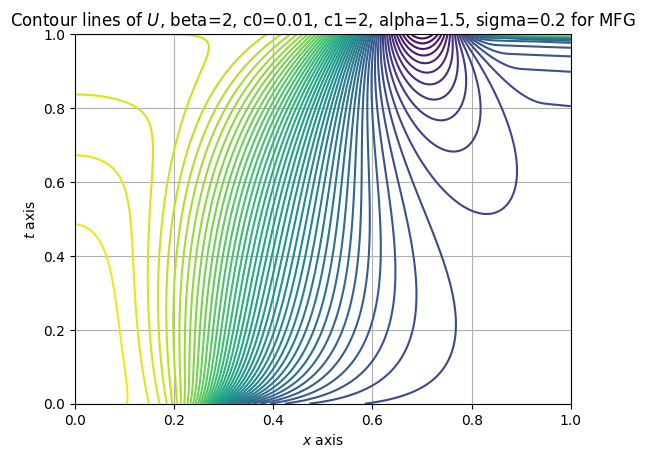

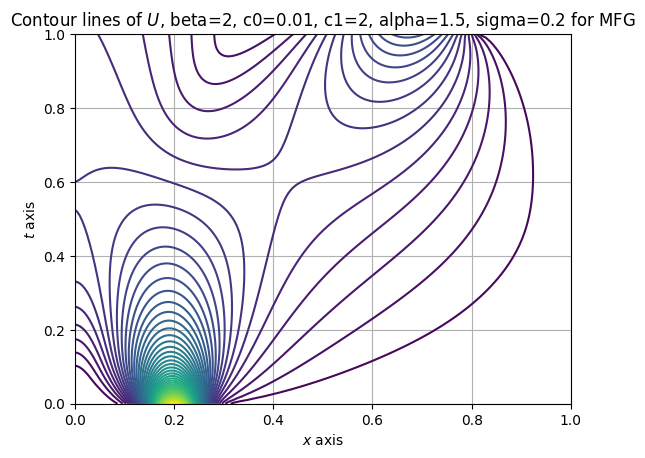

In [ ]:
# Initial conditions
M = np.zeros((NT+1, Nh))
M[:] = m0_hat(space_)

U = np.zeros((NT+1, Nh))
U[:] = phi(space_)

# Solving the equations
U_solv, M_solv = Fixed_Point(U, M)

# Saving the results
file_name_suffix = f"beta{str(beta).replace('.', 'virgule')}"

with open(f'U_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, U_solv)
with open(f'M_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, M_solv)

# Plotting the results
plt.contour(space_, time_, U_solv, levels=60)
plt.title(f"Contour lines of $U$, beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for MFG")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.grid()
plt.show()

plt.contour(space_, time_, M_solv, levels=60)
plt.grid()
plt.title(f"Contour lines of $U$, beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for MFG")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.show()

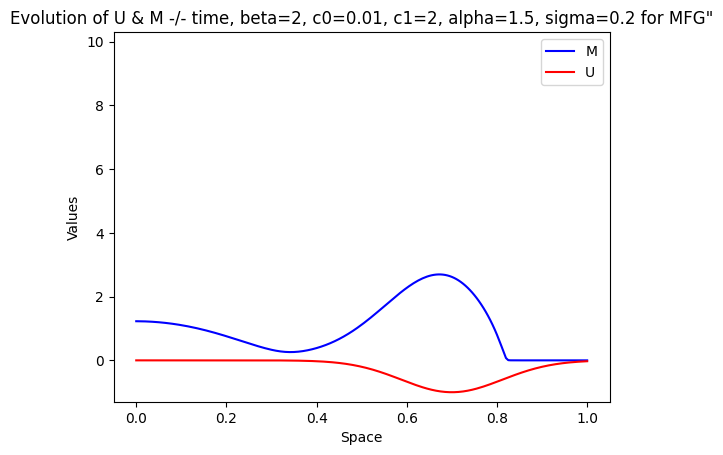

In [ ]:
# Animation
fig, ax = plt.subplots()

line1, = ax.plot(space_, M_solv[0, :], color='blue', label='M')
line2, = ax.plot(space_, U_solv[0, :], color='red', label='U')

ax.legend(loc='best')
ax.set_title(f'Evolution of U & M -/- time, beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for MFG"')
ax.set_xlabel('Space')
ax.set_ylabel('Values')

def init():
    line1.set_ydata([np.nan] * len(space_))
    line2.set_ydata([np.nan] * len(space_))
    return line1, line2

def animate(i):
    line1.set_ydata(M_solv[i, :])
    line2.set_ydata(U_solv[i, :])
    return line1, line2

# Create animation
ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=100, blit=True, frames=len(time_)
)
ani.save('video_mfg.mp4', writer='ffmpeg')


# Display animation
HTML(ani.to_jshtml())

## Twist to the problem : Mean field Control



The key points modification lies in the Hamitonian operator modification, the residual function modifiation and some of the jacobian.


Iteration 0, previous norm: inf, theta: 0.02, elapsed time: 1.1682510375976562e-05
Iteration 1, previous norm: 7.336660688702963, theta: 0.02, elapsed time: 0.41728687286376953
Iteration 2, previous norm: 6.64915424373627, theta: 0.02, elapsed time: 0.7950093746185303
Iteration 3, previous norm: 6.745469994270958, theta: 0.02, elapsed time: 2.0203733444213867
Iteration 4, previous norm: 7.016411351765545, theta: 0.02, elapsed time: 3.386883497238159
Iteration 5, previous norm: 6.728879521187372, theta: 0.02, elapsed time: 4.5015339851379395
Iteration 6, previous norm: 6.39011249494796, theta: 0.02, elapsed time: 4.912091493606567
Iteration 7, previous norm: 6.091115365526021, theta: 0.02, elapsed time: 5.314271688461304
Iteration 8, previous norm: 5.836115470902103, theta: 0.02, elapsed time: 5.723705530166626
Iteration 9, previous norm: 5.61989165594401, theta: 0.02, elapsed time: 6.176804542541504
Iteration 10, previous norm: 5.43652612719825, theta: 0.02, elapsed time: 7.63584852218

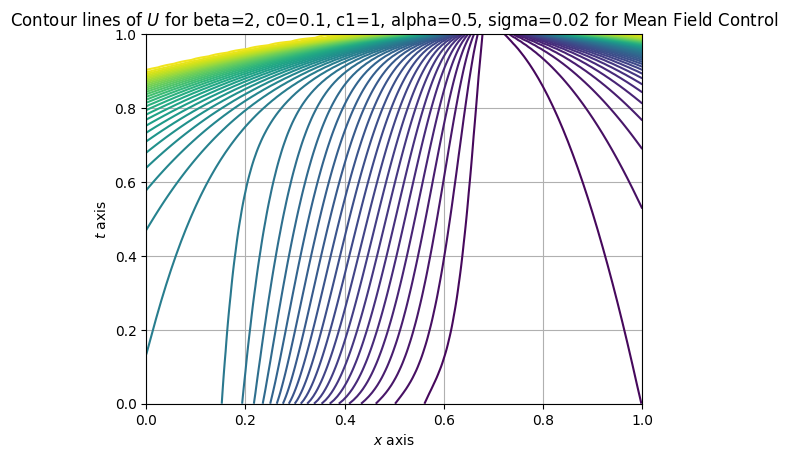

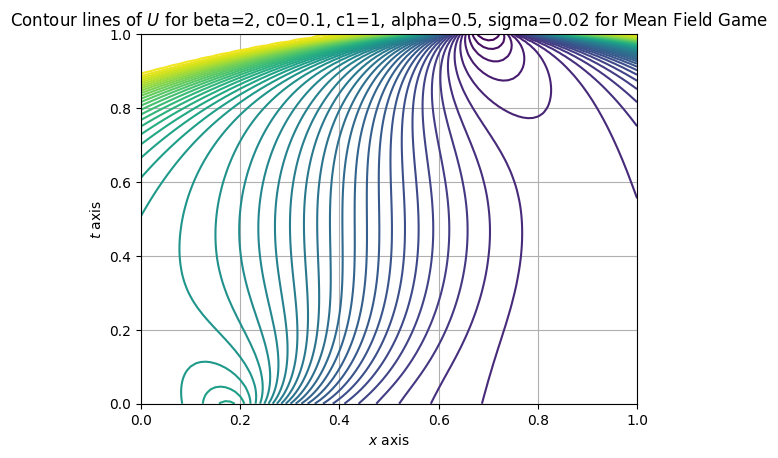

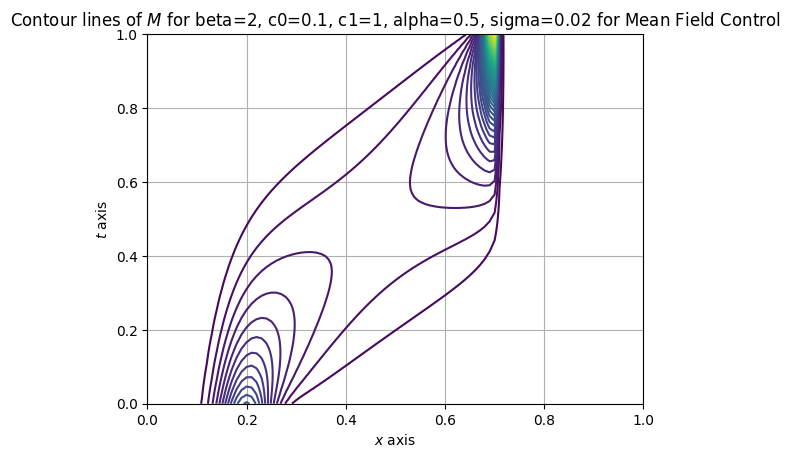

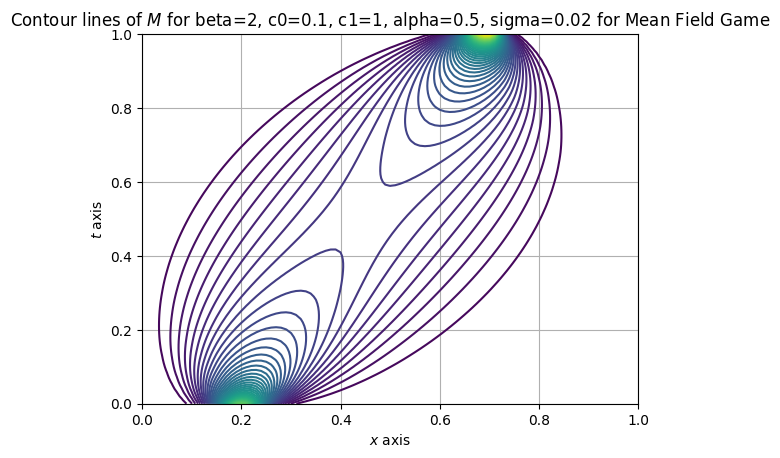

In [ ]:

T = 1
params = {
    0: (2, 0.1, 1, 0.5, 0.02), # theta = 0.09 & the set of parameters considered for the comparison note that f0_tilda will be put to 0 !
}

# Selecting a parameter set
beta, c0, c1, alpha, sigma = params[0] # manually set the parameters here
nu = sigma**2/2
Nh = 101 # Number of space grid points
NT = 100 # Number of time grid points
dt = T/NT # Time step
h = 1/(Nh - 1) # Space step
time_ = np.arange(0, T+dt, dt) # Time grid
space_ = np.arange(0, 1+h, h) # Space grid
newton_tol = 1e-12 # 1e-12 Seems to be too small
fixed_point_tol = 1e-6 # Optimally we put 1e-6 but if it takes "too long" we can put 1e-3

theta = 0.02

def m0(x):
    return np.sqrt(300/np.pi) * np.exp(-300 * (x - 0.2)**2)

def phi(x, m=None):
    return -np.exp(-40 * (x - 0.7)**2)


def m0_hat(x):
    return m0(x)

## Spatial Operators

# Derivatives operators : @i
D = np.diag([-1]*Nh) + np.diag([1]*(Nh-1), k=1)
D[Nh-1, Nh-1] = 0 # Boundary condition

# Derivatives operators : @i-1
D_shift = np.diag([1]*Nh) + np.diag([-1]*(Nh-1), k=-1)
D_shift[0, 0] = 0 # Boundary condition

# Laplacian
D_2 = np.diag([-2]*Nh) + np.diag([1]*(Nh-1), k=1) + np.diag([1]*(Nh-1), k=-1)
D_2[0, 0], D_2[Nh-1, Nh-1] = -1, -1 # Boundary conditions
D_2 = D_2/h**2


def F_2(U_n_plus_1, U_n_k, M_n_plus_1):
    F = - (U_n_plus_1 - U_n_k)/dt  - nu*D_2@U_n_k
    F +=  1/beta * (np.minimum(D@U_n_k / h, 0)**2 + (np.maximum(D_shift@U_n_k / h, 0))**2)**(beta/2) * 1 / ((c0 + c1*M_n_plus_1)**alpha)
    F -= ((c1 * alpha  * M_n_plus_1)/(beta *((c0 + c1*M_n_plus_1)**(alpha+1)))) * (np.minimum(D@U_n_k / h, 0)**2 + (np.maximum(D_shift@U_n_k / h, 0))**2)**(beta/2)
    return F

def hamiltonian_jacobian_2(U, M_JH):

    pos = np.maximum(D_shift@U, 0)
    neg = - np.minimum(D@U, 0)

    factor = pos**2 + neg**2
    factor = np.power(factor, beta/2-1, out=np.zeros_like(factor), where=(factor!=0))

    diag = ((1/h**beta)      *(1/((c0 + c1 * M_JH)**alpha))* (neg + pos) * factor) # [i,i]
    diag_p = (-((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  pos * factor)[1:]  #[i+1, i]
    diag_m = (-((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  neg* factor)[:-1]   #[i, i+1]

    jac = np.diag(diag_p, k=-1) + np.diag(diag) + np.diag(diag_m, k=+1) # Dense matrix for solve() methods

    return jac

def jacobian_2(U, M_JB):

    pos = np.maximum(D_shift@U, 0)
    neg = - np.minimum(D@U, 0)

    factor = pos**2 + neg**2
    factor = np.power(factor, beta/2-1, out=np.zeros_like(factor), where=(factor!=0))

    diag = ((1/h**beta)        *((1/((c0 + c1 * M_JB)**alpha)) - ((c1*alpha*M_JB)/((c0 + c1*M_JB)**(alpha+1))))* (neg + pos) * factor) # [i,i]
    diag_p = (-1 *((1/h**beta)) *((1/((c0 + c1 * M_JB)**alpha)) - ((c1*alpha*M_JB)/((c0 + c1*M_JB)**(alpha+1))))*  pos * factor)[1:]  #[i+1, i]
    diag_m = (-1 *((1/h**beta)) *((1/((c0 + c1 * M_JB)**alpha)) - ((c1*alpha*M_JB)/((c0 + c1*M_JB)**(alpha+1))))*  neg* factor)[:-1]   #[i, i+1]

    jac = np.zeros((3, U.size))
    jac[0, 1:] = diag_m - nu/h**2
    jac[1] = diag + 1/dt + 2*nu/h**2 # résoudre Id / delta t et donc le reporter sur les equations
    jac[2, :-1] = diag_p - nu/h**2


    return jac

def newton_2(U, M):

    U_k = U.copy()
    normF = np.inf
    while normF > newton_tol:
        F = F_2(U, U_k, M)
        J = jacobian_2(U_k, M)

        # To avoid numerical error when c0 is too small (as a term will explode) we decide to not divide by delta t but rewrite our equation to solve it
        F *= dt
        J *= dt

        U_k = U_k - scipy.linalg.solve_banded((1, 1), J, F) # Solve the linear system as the matrix is banded we use solve_banded

        normF = np.linalg.norm(F)

    return U_k # Return the solution at the end of the Newton Raphson method


def solve_HJB_2(M_HJB):

    U_hat = np.zeros(M_HJB.shape)
    U_hat[NT] = phi(space_)

    # Backward loop
    for n in range(NT-1, -1, -1):
        U_hat[n] = newton_2(U_hat[n+1], M_HJB[n+1]) # Solve the HJB equation for each time step

    return U_hat # Return the solution of the HJB equation

def solve_KFP_2(U, M_old):

    M_hat = np.zeros(U.shape)
    M_hat[0] = m0_hat(space_)

    # Forward loop
    for n in range(NT):
        JH = hamiltonian_jacobian(U[n], M_old[n])
        M_hat[n+1] = np.linalg.solve(np.identity(Nh) - nu*dt*D_2+dt*JH.T, M_hat[n])

    return M_hat

def Fixed_Point_2(U_fixed, M_fixed, theta):
    t0 = time.time() # Start time
    k = 0 # Iteration counter

    norm_increment = np.inf # Initialize the norm of the increment


    while norm_increment > fixed_point_tol:
        print(f"Iteration {k}, previous norm: {norm_increment}, theta: {theta}, elapsed time: {time.time() - t0}")

        U_hat = solve_HJB_2(M_fixed)
        M_hat = solve_KFP_2(U_hat, M_fixed)

        U_new = (1 - theta) * U_fixed + theta * U_hat
        M_new = (1 - theta) * M_fixed + theta * M_hat

        increment = np.hstack((U_new - U_fixed, M_new - M_fixed))

        norm_increment_new = np.linalg.norm(increment)
        #if norm_increment_new > norm_increment:
            #theta *= 0.9
        norm_increment = norm_increment_new

        k += 1

        U_fixed, M_fixed = U_new, M_new

    return U_new, M_new

# Initial conditions
M_2 = np.zeros((NT+1, Nh))
M_2[:] = m0_hat(space_)

U_2 = np.zeros((NT+1, Nh))
U_2[:] = phi(space_)

# Solving the equations
U_solv_2, M_solv_2 = Fixed_Point_2(U_2, M_2, theta)
U_solv_1, M_solv_1 = Fixed_Point(U_2, M_2)

# Saving the results
file_name_suffix = f"beta{str(beta).replace('.', 'virgule')}"

with open(f'U_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, U_solv_2)
with open(f'M_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, M_solv_2)

# Plotting the results
plt.contour(space_, time_, U_solv_2, levels=50)
plt.title(f"Contour lines of $U$ for beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for Mean Field Control")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.grid()
plt.show()

plt.contour(space_, time_, U_solv_1, levels=50)
plt.grid()
plt.title(f"Contour lines of $U$ for beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for Mean Field Game")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.show()

plt.contour(space_, time_, M_solv_2, levels=50)
plt.title(f"Contour lines of $M$ for beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for Mean Field Control")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.grid()
plt.show()

plt.contour(space_, time_, M_solv_1, levels=50)
plt.grid()
plt.title(f"Contour lines of $M$ for beta={beta}, c0={c0}, c1={c1}, alpha={alpha}, sigma={sigma} for Mean Field Game")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.show()